<a href="https://colab.research.google.com/github/NitishaS-812k/DTMF-Encoder-Decoder/blob/master/DTMF_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#libraries needed
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [2]:
#system clock
Fs = 24000

In [3]:
def dtmf_encoder(number):
  '''
  Args: Number as a string
  Returns: A conactenated array of tones represented by each numeral in number
  '''
  #dictionary mapping each number to a tuple of its coprime frequencies
  dtmf_mapping = {
      '1' : (697, 1209),
      '2' : (697, 1336),
      '3' : (697, 1477),
      '4' : (770, 1209),
      '5' : (770, 1336),
      '6' : (770, 1477),
      '7' : (852, 1209),
      '8' : (852, 1336),
      '9' : (852, 1477),
      '*' : (941, 1209),
      '0' : (941, 1336),
      '#' : (941, 1477)
  }

  m = 0.1 #length of each tone
  s = 0.2 #space between tones
  x = np.array([])
  n = np.arange(0, int(m*Fs))
  for num in number:
    p = np.sin(2*np.pi*(dtmf_mapping[num][0]/Fs)*n) + np.sin(2*np.pi*(dtmf_mapping[num][1]/Fs)*n)
    space = np.zeros(int(s*Fs))
    x = np.concatenate((x, p, space))
  return x

In [4]:
tone_1 = dtmf_encoder('1498*0')
IPython.display.Audio(tone_1, rate = Fs)

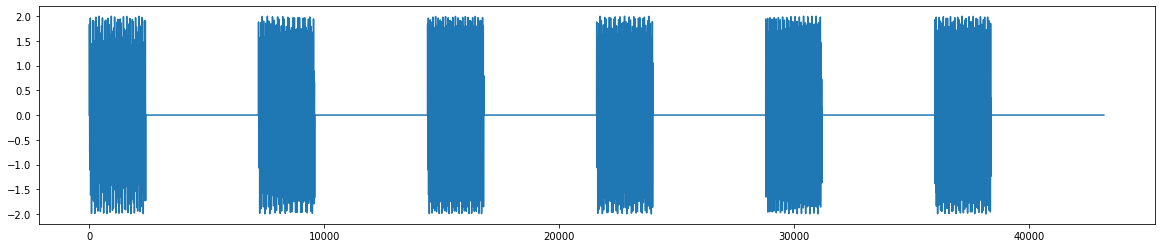

In [5]:
plt.figure(figsize = (20,4))
plt.plot(tone_1)

In [6]:
tone_2 = dtmf_encoder('76589410')
IPython.display.Audio(tone_2, rate = Fs)

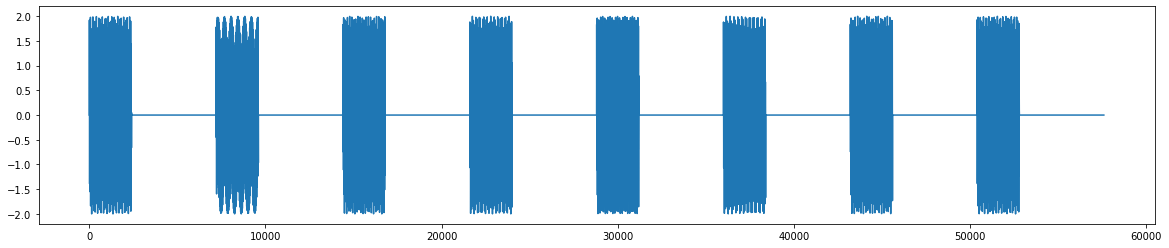

In [7]:
plt.figure(figsize = (20,4))
plt.plot(tone_2)

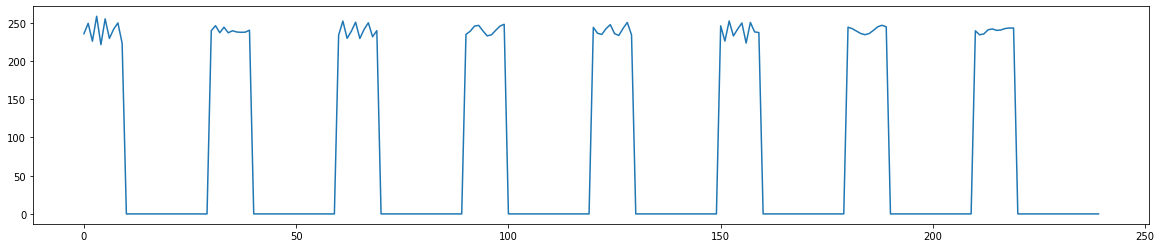

In [8]:
#taking 240 samples chunk and arrange them as a matrix
w = np.reshape(tone_2[:int(len(tone_2)/240)*240], (-1,240))

#this is a 10ms interval..

#compute energy of the tone
w_energy = np.sum(w*w, axis = 1)

#plot it
plt.figure(figsize = (20,4))
plt.plot(w_energy)

In [11]:
#from the plot, a threshold of 200 is enough to separate sound and silence
#based on that we can define a function that returns the start and stop indices of the tones
def split_dtmf(x, win = 240, th= 200):
  '''
  Args: x : the signal
        win: The window size, default is 240
        th: The threshold, default is 200
  Returns:
        edges: A list of tuples with start and stop indices of each tone
  '''
  edges = []
  w = np.reshape(x[:int(len(x)/win)*win], (-1, win))
  w_e = np.sum(w*w, axis = 1)
  L = len(w_e)

  idx = 0
  while idx<L:
    while idx < L and w_e[idx] < th:
      idx = idx + 1
    if idx >= L:
      break
    i = idx
    while i < L and w_e[i] > th:
      i = i + 1
    edges.append((idx*win, i*win))
    idx = i

  return edges 

In [12]:
print(split_dtmf(tone_2))

[(0, 2400), (7200, 9600), (14400, 16800), (21600, 24000), (28800, 31200), (36000, 38400), (43200, 45600), (50400, 52800)]


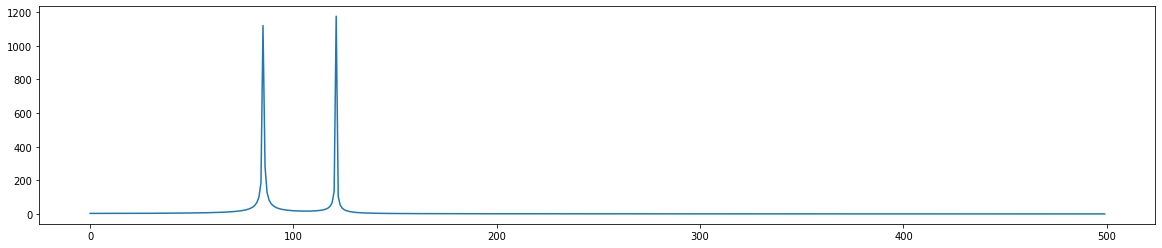

In [13]:
X = np.abs(np.fft.fft((tone_2[0:2400])))
plt.figure(figsize = (20,4))
plt.plot(X[0:500])

In [14]:
def decode_dtmf(x, edges = None):
  '''
  Args: x: the signal
        edges: list of tuples
  Returns: number
  '''
  L_Freqs = np.array([697.0, 770.0, 852.0, 941.0])
  H_Freqs = np.array([1209.0, 1336.0, 1477.0])
  KEYS = [['1', '2', '3'], ['4', '5', '6'], ['7', '8', '9'], ['*', '0', '#']]

  L_RANGE = (680.0, 960.0)
  H_RANGE = (1180.0, 1500.0)

  number = []
  if edges is None:
    edges = split_dtmf(x)
  for edge in edges:
    #compute dft of tone segment
    X = np.abs(np.fft.fft(x[edge[0]:edge[1]]))
    N = len(X)
    res = float(Fs)/N #resolution of each DFT bin

    #look for peak in low frequency range
    a = int(L_RANGE[0]/res)
    b = int(L_RANGE[1]/res)
    lo = a + np.argmax(X[a:b])

    #look for peak in high frequency range
    a = int(H_RANGE[0]/res)
    b = int(H_RANGE[1]/res)
    hi = a + np.argmax(X[a:b])

    row = np.argmin(abs(L_Freqs - lo*res))
    col = np.argmin(abs(H_Freqs - hi*res))

    number.append(KEYS[row][col])
  return number

In [15]:
print(decode_dtmf(tone_2)) # works perfectly!!

['7', '6', '5', '8', '9', '4', '1', '0']


In [16]:
print(decode_dtmf(tone_1))

['1', '4', '9', '8', '*', '0']


In [17]:
#test our decoder with some random noise
noisy_tone_2 = tone_2 + np.random.uniform(-2,2,len(tone_2))
IPython.display.Audio(noisy_tone_2, rate = Fs)

In [18]:
decode_dtmf(noisy_tone_2) #fails!

['8']

In [22]:
#threshold can't be set manually, it must be calculated depending on the signal
decode_dtmf(tone_2, split_dtmf(tone_2, th = 220))

['7', '6', '5', '8', '9', '4', '1', '0']

In [23]:
decode_dtmf(tone_2, split_dtmf(tone_2, th = 250)) #fails when threshold isn't set properly!

['4', '4', '5', '5', '5', '4', '4']